# 1. Analysis of employee data using SQL in Python

For the analysis, the Employees database was used.

Repository with dumps of this database: https://github.com/datacharmer/test_db  
Database structure: https://dev.mysql.com/doc/employee/en/sakila-structure.html

1.1. Installation of the `mysql-connector-python` library

In [1]:
!pip install mysql-connector-python


In [2]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime
import pandas as pd
import matplotlib.pyplot as plt


1.2. The variable `con` holds the connection to the `employees` database.

In [3]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')


1.3. The maximum and minimum hire dates of employees were selected using `con.cursor()`. To retrieve the results, `cursor.fetchall()` was executed at the end.

In [4]:
cursor = con.cursor()


In [5]:
cursor.execute("SELECT MAX(hire_date), MIN(hire_date) FROM employees")


In [6]:
result = cursor.fetchall()


In [7]:
result


[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

1.4. Let's gather information about the last salary for each employee in the database. Using `con.cursor()`, it was selected from the `salaries` table the employee number, the most recent salary in the database (i.e., the one corresponding to the latest `to_date`), and the `from_date` and `to_date` values for that salary.

The results were stored in a pandas DataFrame, which was saved in the variable `res`. The column names in `res`, the size of the DataFrame, and the first three records were displayed.

When performing this task, it was considered that a salary could be updated multiple times within a single day. For instance, if a salary update occurred on a specific day, say 2001-01-01, and another update followed later on the same day, the query accounts for this. Additionally, the salary might be decreased, so selecting the date with the highest salary would be incorrect from a business logic perspective. Therefore, the most recent historical salary value for each employee was used.

In [8]:
query = """
    SELECT s.emp_no, s.salary, s.from_date, s.to_date
    FROM salaries s
    JOIN (
        SELECT emp_no, MAX(from_date) as max_from_date, MAX(to_date) as max_to_date
        FROM salaries
        GROUP BY emp_no
    ) max_dates
    ON s.emp_no = max_dates.emp_no AND s.from_date = max_dates.max_from_date AND s.to_date = max_dates.max_to_date
"""

cursor.execute(query)

columns = [i[0] for i in cursor.description]
data = cursor.fetchall()
res = pd.DataFrame(data, columns=columns)


In [9]:
res.columns


Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')

In [10]:
res.shape


(300024, 4)

In [11]:
res.head(3)


,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


1.5. Let's determine how many `to_date` values in the dataset stored in the variable `res` are equal to `9999-01-01`, and how many are not. To complete this task, it's important to understand the data type of the `to_date` column values. Therefore, this was identified first, and then a filter was applied to output the required result.

In [12]:
to_date_dtype = res['to_date'].dtype


In [13]:
print(to_date_dtype)


object


In [14]:
to_date_9999_count = len(res[res['to_date'].astype(str) == '9999-01-01'])
to_date_not_9999_count = len(res[res['to_date'].astype(str) != '9999-01-01'])

print("The number of to_date values equal to '9999-01-01':", to_date_9999_count)
print("The number of to_date values not equal to '9999-01-01':", to_date_not_9999_count)


The number of to_date values equal to '9999-01-01': 240124
The number of to_date values not equal to '9999-01-01': 59900


1.6. Displayed a visual distribution (histogram) of the salaries of employees who are still working at the company, using the results from the previous task. Employees who are still working at the company are those whose `to_date` is equal to '9999-01-01.' These three tasks are an example of how it can be convenient to extract data from a database using a specific query and then use the extracted dataset in Python for further analysis.

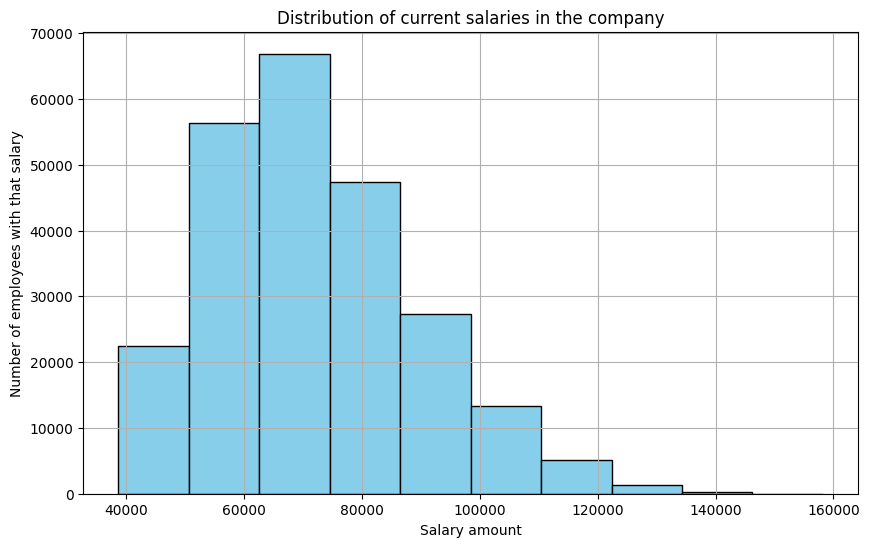

In [15]:
still_working = res[res['to_date'].astype(str) == '9999-01-01']

plt.figure(figsize=(10, 6))
plt.hist(still_working['salary'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of current salaries in the company')
plt.xlabel('Salary amount')
plt.ylabel('Number of employees with that salary')
plt.grid(True)
plt.show()


# 2. Analysis of employee data using Pandas + SQL

For the analysis, the same Employees database was used.

In [16]:
import warnings

warnings.filterwarnings('ignore')

2.1. The number of employees by the year they were hired (hire_date) has been extracted using pandas.read_sql. The result was stored in the variable df and the value of the variable was displayed on the screen.

In [17]:
query = '''
SELECT YEAR(hire_date) AS hire_year, COUNT(*) AS emp_num
FROM employees
GROUP BY hire_year;
'''

df = pd.read_sql(query, con)


In [18]:
df


,hire_year,emp_num
0,1986,36150
1,1985,35316
2,1989,28394
3,1994,14835
4,1990,25610
5,1992,20402
6,1987,33501
7,1995,12115
8,1993,17772
9,1999,1514


2.2. Now let's plot a line graph showing the number of hired employees by year of hire. For this, the column names of the dataframe were renamed. Additionally, to ensure the graph is correct, the years were sorted in ascending order.

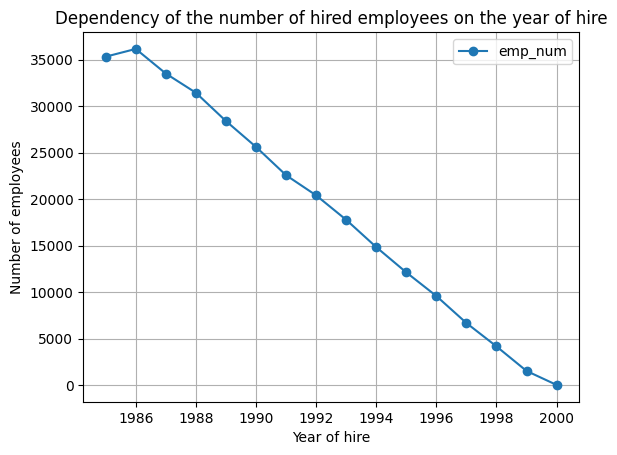

In [19]:
query = '''
SELECT YEAR(hire_date) AS hire_year, COUNT(*) AS employee_count
FROM employees
GROUP BY hire_year
ORDER BY hire_year;
'''

df = pd.read_sql(query, con)

df.columns = ['Year of hire', 'Number of employees']

plt.plot(df['Year of hire'], df['Number of employees'], marker='o', label='emp_num')
plt.title('Dependency of the number of hired employees on the year of hire')
plt.xlabel('Year of hire')
plt.ylabel('Number of employees')
plt.legend()
plt.grid(True)
plt.show()


2.3. Using SQL, for employees with the position `Engineer` who are no longer with the company (i.e., those with a `to_date` value that is not the default value), let's find the number of full years they spent in the position. The position is stored in the `title` column in the `titles` table. The number of years in the position was obtained using the `timestampdiff` function. The result was stored in the variable `df_years` and this variable was displayed on the screen.

In [20]:
query = """
SELECT
    CASE
        WHEN hire_date < from_date THEN
            TIMESTAMPDIFF(YEAR, from_date, to_date)
        ELSE
            TIMESTAMPDIFF(YEAR, hire_date, to_date)
            - IF(DAYOFYEAR(hire_date) > DAYOFYEAR(from_date), 1, 0)
    END AS duration,
    from_date,
    to_date
FROM
    employees
JOIN
    titles USING(emp_no)
WHERE
    title = 'Engineer' AND
    to_date != '9999-01-01';
"""

df_years = pd.read_sql(query, con)


In [21]:
df_years


,duration,from_date,to_date
0,9,1986-12-01,1995-12-01
1,5,1990-02-18,1995-02-18
2,8,1992-12-18,2000-12-18
3,8,1987-04-03,1995-04-03
4,5,1995-03-20,2001-03-19
...,...,...,...
84015,9,1989-11-23,1998-11-23
84016,5,1989-07-30,1994-07-30
84017,0,1993-02-22,1993-10-27
84018,6,1996-05-13,2002-05-13


2.4. Using the data in `df_years`, a histogram was created showing the number of years employees with the position title `Engineer` spent in the role.

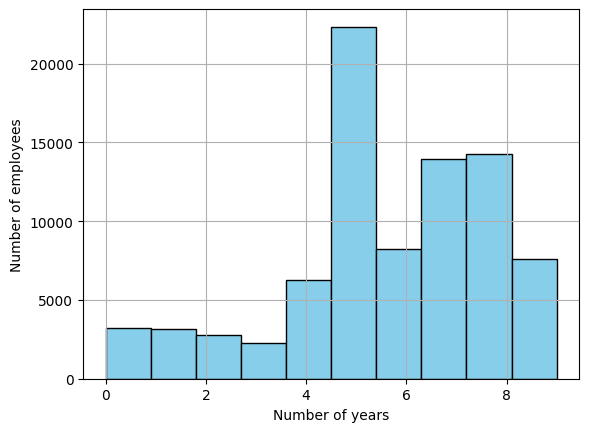

In [22]:
plt.hist(df_years['duration'], bins=10, color='skyblue', edgecolor='black')

plt.xlabel('Number of years')
plt.ylabel('Number of employees')
plt.grid(True)
plt.show()


Close connection:

In [23]:
con.close()